# GSVA With MSigDB KEGG Pathways in R

Author: Jon Katz  
Date:   2021-10-22  
Description: Example GSVA, with bonus DGE using GSVA values

Steps:

    1. Download all 186 KEGG gene sets from MSigDB
    2. Request expression data
    3. Shape expression data
    4. Gene Set Variation Analysis
    5. Semi-clustered heatmap
    6. Clustered heatmap
    7. DGE of GSVA, colorectal and breast cancers
    8. Volcano plot

This notebook uses Champions NGS data to implement two of the examples from the vignette in the R package GSVA: https://bioconductor.org/packages/devel/bioc/vignettes/GSVA/inst/doc/GSVA.html#6_Example_applications. The most time consuming part is installing GSVA. After that the data request (~1.5m rows) and subsequent manipulation feel pretty snappy.

In [2]:
library(httr)
library(jsonlite)
if(!'BiocManager' %in% rownames(installed.packages())) { 
  install.packages('BiocManager') 
  library(BiocManager)
  BiocManager::install('GSVA') # expect this install to take ~ 15-25 minutes
  BiocManager::install('limma')   
}
library(GSVA)
library(limma)
library(tidyr)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'GSVA'

also installing the dependencies ‘zlibbioc’, ‘png’, ‘Biostrings’, ‘formatR’, ‘XVector’, ‘GenomeInfoDbData’, ‘KEGGREST’, ‘lambda.r’, ‘futile.options’, ‘BiocGenerics’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘GenomeInfoDb’, ‘annotate’, ‘graph’, ‘AnnotationDbi’, ‘XML’, ‘futile.logger’, ‘snow’, ‘BH’, ‘matrixStats’, ‘rhdf5’, ‘rhdf5filters’, ‘Rhdf5lib’, ‘ScaledMatrix’, ‘irlba’, ‘rsvd’, ‘beachmat’, ‘S4Vectors’, ‘IRanges’, ‘Biobase’, ‘SummarizedExperiment’, ‘GSEABase’, ‘BiocParallel’, ‘SingleCellExperiment’, ‘sparseMatrixStats’, ‘DelayedArray’, ‘DelayedMatrixStats’, ‘HDF5Array’, ‘BiocSingular’


Updating HTML index of packages in '.Library'

Ma

## 1. Download All 186 KEGG Gene Sets

In [3]:
# get MSigDB gene set, save to disk and read in as tsv
genesetfile <- tempfile()
geneset <- list()
get_sets <- c(
    "KEGG_ABC_TRANSPORTERS",
    "KEGG_ACUTE_MYELOID_LEUKEMIA",
    "KEGG_ADHERENS_JUNCTION",
    "KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY",
    "KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM",
    "KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION",
    "KEGG_ALLOGRAFT_REJECTION",
    "KEGG_ALPHA_LINOLENIC_ACID_METABOLISM",
    "KEGG_ALZHEIMERS_DISEASE",
    "KEGG_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM",
    "KEGG_AMINOACYL_TRNA_BIOSYNTHESIS",
    "KEGG_AMYOTROPHIC_LATERAL_SCLEROSIS_ALS",
    "KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION",
    "KEGG_APOPTOSIS",
    "KEGG_ARACHIDONIC_ACID_METABOLISM",
    "KEGG_ARGININE_AND_PROLINE_METABOLISM",
    "KEGG_ARRHYTHMOGENIC_RIGHT_VENTRICULAR_CARDIOMYOPATHY_ARVC",
    "KEGG_ASCORBATE_AND_ALDARATE_METABOLISM",
    "KEGG_ASTHMA",
    "KEGG_AUTOIMMUNE_THYROID_DISEASE",
    "KEGG_AXON_GUIDANCE",
    "KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY",
    "KEGG_BASAL_CELL_CARCINOMA",
    "KEGG_BASAL_TRANSCRIPTION_FACTORS",
    "KEGG_BASE_EXCISION_REPAIR",
    "KEGG_BETA_ALANINE_METABOLISM",
    "KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS",
    "KEGG_BLADDER_CANCER",
    "KEGG_BUTANOATE_METABOLISM",
    "KEGG_CALCIUM_SIGNALING_PATHWAY",
    "KEGG_CARDIAC_MUSCLE_CONTRACTION",
    "KEGG_CELL_ADHESION_MOLECULES_CAMS",
    "KEGG_CELL_CYCLE",
    "KEGG_CHEMOKINE_SIGNALING_PATHWAY",
    "KEGG_CHRONIC_MYELOID_LEUKEMIA",
    "KEGG_CIRCADIAN_RHYTHM_MAMMAL",
    "KEGG_CITRATE_CYCLE_TCA_CYCLE",
    "KEGG_COLORECTAL_CANCER",
    "KEGG_COMPLEMENT_AND_COAGULATION_CASCADES",
    "KEGG_CYSTEINE_AND_METHIONINE_METABOLISM",
    "KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION",
    "KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY",
    "KEGG_DILATED_CARDIOMYOPATHY",
    "KEGG_DNA_REPLICATION",
    "KEGG_DORSO_VENTRAL_AXIS_FORMATION",
    "KEGG_DRUG_METABOLISM_CYTOCHROME_P450",
    "KEGG_DRUG_METABOLISM_OTHER_ENZYMES",
    "KEGG_ECM_RECEPTOR_INTERACTION",
    "KEGG_ENDOCYTOSIS",
    "KEGG_ENDOMETRIAL_CANCER",
    "KEGG_EPITHELIAL_CELL_SIGNALING_IN_HELICOBACTER_PYLORI_INFECTION",
    "KEGG_ERBB_SIGNALING_PATHWAY",
    "KEGG_ETHER_LIPID_METABOLISM",
    "KEGG_FATTY_ACID_METABOLISM",
    "KEGG_FC_EPSILON_RI_SIGNALING_PATHWAY",
    "KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS",
    "KEGG_FOCAL_ADHESION",
    "KEGG_FOLATE_BIOSYNTHESIS",
    "KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM",
    "KEGG_GALACTOSE_METABOLISM",
    "KEGG_GAP_JUNCTION",
    "KEGG_GLIOMA",
    "KEGG_GLUTATHIONE_METABOLISM",
    "KEGG_GLYCEROLIPID_METABOLISM",
    "KEGG_GLYCEROPHOSPHOLIPID_METABOLISM",
    "KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM",
    "KEGG_GLYCOLYSIS_GLUCONEOGENESIS",
    "KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_CHONDROITIN_SULFATE",
    "KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_HEPARAN_SULFATE",
    "KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN_SULFATE",
    "KEGG_GLYCOSAMINOGLYCAN_DEGRADATION",
    "KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GANGLIO_SERIES",
    "KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES",
    "KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_LACTO_AND_NEOLACTO_SERIES",
    "KEGG_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI_ANCHOR_BIOSYNTHESIS",
    "KEGG_GLYOXYLATE_AND_DICARBOXYLATE_METABOLISM",
    "KEGG_GNRH_SIGNALING_PATHWAY",
    "KEGG_GRAFT_VERSUS_HOST_DISEASE",
    "KEGG_HEDGEHOG_SIGNALING_PATHWAY",
    "KEGG_HEMATOPOIETIC_CELL_LINEAGE",
    "KEGG_HISTIDINE_METABOLISM",
    "KEGG_HOMOLOGOUS_RECOMBINATION",
    "KEGG_HUNTINGTONS_DISEASE",
    "KEGG_HYPERTROPHIC_CARDIOMYOPATHY_HCM",
    "KEGG_INOSITOL_PHOSPHATE_METABOLISM",
    "KEGG_INSULIN_SIGNALING_PATHWAY",
    "KEGG_INTESTINAL_IMMUNE_NETWORK_FOR_IGA_PRODUCTION",
    "KEGG_JAK_STAT_SIGNALING_PATHWAY",
    "KEGG_LEISHMANIA_INFECTION",
    "KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION",
    "KEGG_LIMONENE_AND_PINENE_DEGRADATION",
    "KEGG_LINOLEIC_ACID_METABOLISM",
    "KEGG_LONG_TERM_DEPRESSION",
    "KEGG_LONG_TERM_POTENTIATION",
    "KEGG_LYSINE_DEGRADATION",
    "KEGG_LYSOSOME",
    "KEGG_MAPK_SIGNALING_PATHWAY",
    "KEGG_MATURITY_ONSET_DIABETES_OF_THE_YOUNG",
    "KEGG_MELANOGENESIS",
    "KEGG_MELANOMA",
    "KEGG_METABOLISM_OF_XENOBIOTICS_BY_CYTOCHROME_P450",
    "KEGG_MISMATCH_REPAIR",
    "KEGG_MTOR_SIGNALING_PATHWAY",
    "KEGG_N_GLYCAN_BIOSYNTHESIS",
    "KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY",
    "KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION",
    "KEGG_NEUROTROPHIN_SIGNALING_PATHWAY",
    "KEGG_NICOTINATE_AND_NICOTINAMIDE_METABOLISM",
    "KEGG_NITROGEN_METABOLISM",
    "KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY",
    "KEGG_NON_HOMOLOGOUS_END_JOINING",
    "KEGG_NON_SMALL_CELL_LUNG_CANCER",
    "KEGG_NOTCH_SIGNALING_PATHWAY",
    "KEGG_NUCLEOTIDE_EXCISION_REPAIR",
    "KEGG_O_GLYCAN_BIOSYNTHESIS",
    "KEGG_OLFACTORY_TRANSDUCTION",
    "KEGG_ONE_CARBON_POOL_BY_FOLATE",
    "KEGG_OOCYTE_MEIOSIS",
    "KEGG_OTHER_GLYCAN_DEGRADATION",
    "KEGG_OXIDATIVE_PHOSPHORYLATION",
    "KEGG_P53_SIGNALING_PATHWAY",
    "KEGG_PANCREATIC_CANCER",
    "KEGG_PANTOTHENATE_AND_COA_BIOSYNTHESIS",
    "KEGG_PARKINSONS_DISEASE",
    "KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION",
    "KEGG_PATHWAYS_IN_CANCER",
    "KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS",
    "KEGG_PENTOSE_PHOSPHATE_PATHWAY",
    "KEGG_PEROXISOME",
    "KEGG_PHENYLALANINE_METABOLISM",
    "KEGG_PHOSPHATIDYLINOSITOL_SIGNALING_SYSTEM",
    "KEGG_PORPHYRIN_AND_CHLOROPHYLL_METABOLISM",
    "KEGG_PPAR_SIGNALING_PATHWAY",
    "KEGG_PRIMARY_BILE_ACID_BIOSYNTHESIS",
    "KEGG_PRIMARY_IMMUNODEFICIENCY",
    "KEGG_PRION_DISEASES",
    "KEGG_PROGESTERONE_MEDIATED_OOCYTE_MATURATION",
    "KEGG_PROPANOATE_METABOLISM",
    "KEGG_PROSTATE_CANCER",
    "KEGG_PROTEASOME",
    "KEGG_PROTEIN_EXPORT",
    "KEGG_PROXIMAL_TUBULE_BICARBONATE_RECLAMATION",
    "KEGG_PURINE_METABOLISM",
    "KEGG_PYRIMIDINE_METABOLISM",
    "KEGG_PYRUVATE_METABOLISM",
    "KEGG_REGULATION_OF_ACTIN_CYTOSKELETON",
    "KEGG_REGULATION_OF_AUTOPHAGY",
    "KEGG_RENAL_CELL_CARCINOMA",
    "KEGG_RENIN_ANGIOTENSIN_SYSTEM",
    "KEGG_RETINOL_METABOLISM",
    "KEGG_RIBOFLAVIN_METABOLISM",
    "KEGG_RIBOSOME",
    "KEGG_RIG_I_LIKE_RECEPTOR_SIGNALING_PATHWAY",
    "KEGG_RNA_DEGRADATION",
    "KEGG_RNA_POLYMERASE",
    "KEGG_SELENOAMINO_ACID_METABOLISM",
    "KEGG_SMALL_CELL_LUNG_CANCER",
    "KEGG_SNARE_INTERACTIONS_IN_VESICULAR_TRANSPORT",
    "KEGG_SPHINGOLIPID_METABOLISM",
    "KEGG_SPLICEOSOME",
    "KEGG_STARCH_AND_SUCROSE_METABOLISM",
    "KEGG_STEROID_BIOSYNTHESIS",
    "KEGG_STEROID_HORMONE_BIOSYNTHESIS",
    "KEGG_SULFUR_METABOLISM",
    "KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS",
    "KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY",
    "KEGG_TASTE_TRANSDUCTION",
    "KEGG_TAURINE_AND_HYPOTAURINE_METABOLISM",
    "KEGG_TERPENOID_BACKBONE_BIOSYNTHESIS",
    "KEGG_TGF_BETA_SIGNALING_PATHWAY",
    "KEGG_THYROID_CANCER",
    "KEGG_TIGHT_JUNCTION",
    "KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY",
    "KEGG_TRYPTOPHAN_METABOLISM",
    "KEGG_TYPE_I_DIABETES_MELLITUS",
    "KEGG_TYPE_II_DIABETES_MELLITUS",
    "KEGG_TYROSINE_METABOLISM",
    "KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS",
    "KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS",
    "KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION",
    "KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION",
    "KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION",
    "KEGG_VEGF_SIGNALING_PATHWAY",
    "KEGG_VIBRIO_CHOLERAE_INFECTION",
    "KEGG_VIRAL_MYOCARDITIS",
    "KEGG_WNT_SIGNALING_PATHWAY"
)
for(set in get_sets) {
    x <- httr::GET('http://www.gsea-msigdb.org/gsea/msigdb/download_geneset.jsp',
        query=list(
            geneSetName = set,
            fileType = 'txt'
        ),
        httr::write_disk(genesetfile, overwrite = TRUE)
    )
    suppressMessages(geneset1 <- readr::read_tsv(genesetfile))
    geneset[set] <- as.list(geneset1)
    Sys.sleep(0.5) # give the website a break so we don't wear out our welcome
}
# first element in each geneset is a descriptor
geneset <- lapply(geneset, function(x) x[-1])
str(geneset,1)

List of 186
 $ KEGG_ABC_TRANSPORTERS                                          : chr [1:44] "ABCA1" "ABCA10" "ABCA12" "ABCA13" ...
 $ KEGG_ACUTE_MYELOID_LEUKEMIA                                    : chr [1:57] "AKT1" "AKT2" "AKT3" "ARAF" ...
 $ KEGG_ADHERENS_JUNCTION                                         : chr [1:73] "ACP1" "ACTB" "ACTG1" "ACTN1" ...
 $ KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY                           : chr [1:67] "ACACB" "ACSL1" "ACSL3" "ACSL4" ...
 $ KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM                : chr [1:32] "ABAT" "ACY3" "ADSL" "ADSS1" ...
 $ KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION                 : chr [1:42] "ATP1A1" "ATP1A2" "ATP1A3" "ATP1A4" ...
 $ KEGG_ALLOGRAFT_REJECTION                                       : chr [1:37] "CD28" "CD40" "CD40LG" "CD80" ...
 $ KEGG_ALPHA_LINOLENIC_ACID_METABOLISM                           : chr [1:19] "ACOX1" "ACOX3" "FADS2" "JMJD7-PLA2G4B" ...
 $ KEGG_ALZHEIMERS_DISEASE                                      

## 2. Request Expression Data
Be kind to the servers, don't be greedy with requests for data.  
This is too many genes for one call, but it is possible if we split it into several calls, each for 1000 genes.

In [4]:
genes <- unique(unlist(geneset))
ncalls <- ceiling(length(genes)/1000)
length(genes)

[1] 5245

### 2a. Make the Request

In [5]:
mydata <- c()
for(i in seq(1, ncalls * 1000, by=1000)) {
    idx <- i:(min(i+999, length(genes)))
    d0 <- list(
        request_data_type = "expression",
        request_cancer_type = list("Breast","Bladder","Colorectal","Lymphoma"),
        request_dataset = "PDX",
        request_genes = genes[idx],
        request_key = "92b0532949f64b5aa88f8362f066e69e92b0532949f64b5aa88f8362f066e69e",
        request_client = 99,
        request_user = 4326,
        request_workspace_id = "4326-99",
        request_mode = 'true'
    )

    r0 <- httr::POST(
        url = "https://lumin-fast-api.championsoncology.com/WS",
        body = jsonlite::toJSON(d0, auto_unbox=TRUE),
        httr::content_type_json()
    )
    
    mydata <- c(mydata, httr::content(r0)$meta$name)
}

### 2b. Which Files to Read?

In [9]:
print(mydata)

[1] "requested_data---25-10-2021---23:07:29 chunk-0.json"
[2] "requested_data---25-10-2021---23:07:46 chunk-0.json"
[3] "requested_data---25-10-2021---23:08:04 chunk-0.json"
[4] "requested_data---25-10-2021---23:08:21 chunk-0.json"
[5] "requested_data---25-10-2021---23:08:35 chunk-0.json"
[6] "requested_data---25-10-2021---23:08:52 chunk-0.json"


### 2c. Read Expression Data

In [7]:
pdx_l <- lapply(mydata, function(x) jsonlite::fromJSON(paste0("../", x)))
pdx_orig <- pdx_dat <- do.call(rbind.data.frame, pdx_l) 
str(pdx_dat,1)

'data.frame':	1505351 obs. of  13 variables:
 $ v1           : int  199539 199544 199545 199550 199551 199554 199566 199567 199568 199583 ...
 $ gene_id      : chr  "ENSG00000001167" "ENSG00000001617" "ENSG00000001626" "ENSG00000002330" ...
 $ log.rsem.rpkm: chr  "3.45302365879983" "1.25769832514563" "6.284144904862" "5.55718759031324" ...
 $ log.tpm      : chr  "4.20879551296001" "1.88506096985335" "7.14846129640044" "6.36199972344752" ...
 $ z            : chr  "-0.776004016902263" "-0.915526465919314" "2.39466962345261" "0.891035060767019" ...
 $ fold         : chr  "0.863218403919886" "0.449566162092208" "4.54689133190706" "1.17840806398327" ...
 $ trans        : chr  "ENST00000341376:81.01% ENST00000353205:18.99%" "ENST00000413852:74.98% ENST00000002829:25.02%" "ENST00000003084:51.28% ENST00000454343:38.92%" "ENST00000309032:86.32%" ...
 $ model        : chr  "CTG-0062" "CTG-0062" "CTG-0062" "CTG-0062" ...
 $ sort_key     : chr  "CTG-0062_Expression_1" "CTG-0062_Expression_1" "CTG

## 3. Shape Expression Data
Rows must correspond to genes and columns correspond to samples.  
Models that have been sequenced more than once are reduced to one value per gene via averaging.

In [154]:
cancertype <- unique(pdx_dat[c('model_name', 'tumor_type')])
pdx_dat$z <- as.numeric(pdx_dat$z)
pdx_dat <- aggregate(pdx_dat['z'], by=pdx_dat[c('gene', 'model_name')], FUN=mean)
pdx_mat <- tidyr::pivot_wider(pdx_dat[c('z', 'gene', 'model_name')], names_from='model_name', values_from='z')
pdx_mat <- as.data.frame(pdx_mat)
rownames(pdx_mat) <- pdx_mat$gene
pdx_mat <- as.matrix(pdx_mat[-1])
pdx_mat[1:10,1:10]

,CTG-0012,CTG-0017,CTG-0018,CTG-0019,CTG-0033,CTG-0052,CTG-0058,CTG-0061,CTG-0062,CTG-0063
A2M,3.1311626,0.17961608,-0.5429933,-0.310153286,-0.4760163,2.303071590,-0.52550168,-0.53752578,-0.4916863,-0.53752578
A4GALT,-0.2895858,-0.67720115,0.7931810,-0.856529884,-1.1092344,0.009585649,0.05519834,-1.04295634,-1.0307588,1.07446486
AACS,0.9943929,-1.76027206,0.4693210,-0.516449182,-0.9509104,-0.405715869,0.84593898,0.30204045,0.2571672,1.14007865
AADAT,0.4792583,0.12852931,-0.7834028,-0.626491798,0.9878927,1.142268900,-0.79393237,0.75161890,0.4989694,0.39689206
AARS2,2.1834815,1.27592015,0.5645837,-1.205378854,-0.3217936,1.224797282,-0.32716337,0.94107138,-0.6705760,-0.56775493
AASDH,-1.2270784,-0.01614017,-0.2768558,-0.074812166,-0.1013776,-0.561277765,-1.97546867,-0.47983035,-0.3690010,-0.09973033
AASDHPPT,-0.8325953,0.34399475,-2.3060672,1.317788395,0.3739758,-0.148404651,0.01060335,-0.07526765,0.1414120,-1.60646890
AASS,0.6452222,-1.11046803,-1.1251549,0.004075233,-1.0121231,-1.304602981,-0.82628985,-0.72146914,-0.2058468,-1.03414090
ABAT,-0.2149880,-0.80318663,-0.6724634,0.373738935,-1.0562532,-0.922020771,1.28339163,0.21199567,-0.2692905,0.60111875
ABCA1,-0.2504983,-1.15588029,-0.7899873,0.764613702,-0.5692278,-0.234757449,-0.94971589,0.10372638,-0.5483704,-0.48149119


## 4. Gene Set Variation Analysis

In [153]:
pdx_gsva <- GSVA::gsva(pdx_mat, geneset, min.sz=10, max.sz=500)
# not a bad idea to save this for later
save(pdx_mat, pdx_gsva, pdx_orig, geneset, genes, file="gsva.RData")
pdx_gsva[,1:8]

Warning message in .filterFeatures(expr, method):
“728 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“Since argument method!="ssgsea", genes with constant expression values are discarded.”


Estimating GSVA scores for 182 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,CTG-0012,CTG-0017,CTG-0018,CTG-0019,CTG-0033,CTG-0052,CTG-0058,CTG-0061
KEGG_ABC_TRANSPORTERS,0.22210755,-0.19131541,-0.1988756043,-0.19770766,0.101354096,-0.317714334,-0.05174234,0.098617014
KEGG_ACUTE_MYELOID_LEUKEMIA,0.12080404,-0.05557256,-0.1404468110,-0.16643889,0.045892923,0.001663715,0.20851198,0.157865453
KEGG_ADHERENS_JUNCTION,-0.01501024,0.28274826,-0.1839344508,-0.04253948,-0.255349856,-0.248936197,0.26204646,0.163851511
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,0.03250476,0.04187597,-0.2253605822,-0.07388420,-0.228460976,-0.212021251,0.18069622,0.012854745
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,-0.19905010,-0.06506157,-0.3344739824,0.18088385,-0.464899730,-0.228518576,0.18307394,0.427487922
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,0.04188531,0.12413113,-0.2297284189,-0.01615737,-0.316012323,-0.078713614,0.21409204,0.097311245
KEGG_ALLOGRAFT_REJECTION,0.37663035,-0.01375949,0.1141823818,0.51959840,-0.050147644,0.235228773,0.36815370,-0.215527123
KEGG_ALPHA_LINOLENIC_ACID_METABOLISM,0.29488917,-0.09023718,-0.2041294562,-0.21413359,0.261808054,-0.071597749,-0.39621609,-0.407645294
KEGG_ALZHEIMERS_DISEASE,-0.33929483,-0.20883699,-0.1280628286,0.17396911,0.001041278,0.145177181,0.13482559,-0.074869649
KEGG_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM,-0.11516375,-0.11836628,0.2040231523,0.09317266,-0.278914791,0.265575318,-0.03586415,0.002927212


## 5. Semi-clustered Heatmap
Only genesets are clustered. Models are grouped by cancer type. The colored bar at the top indicates cancer type.

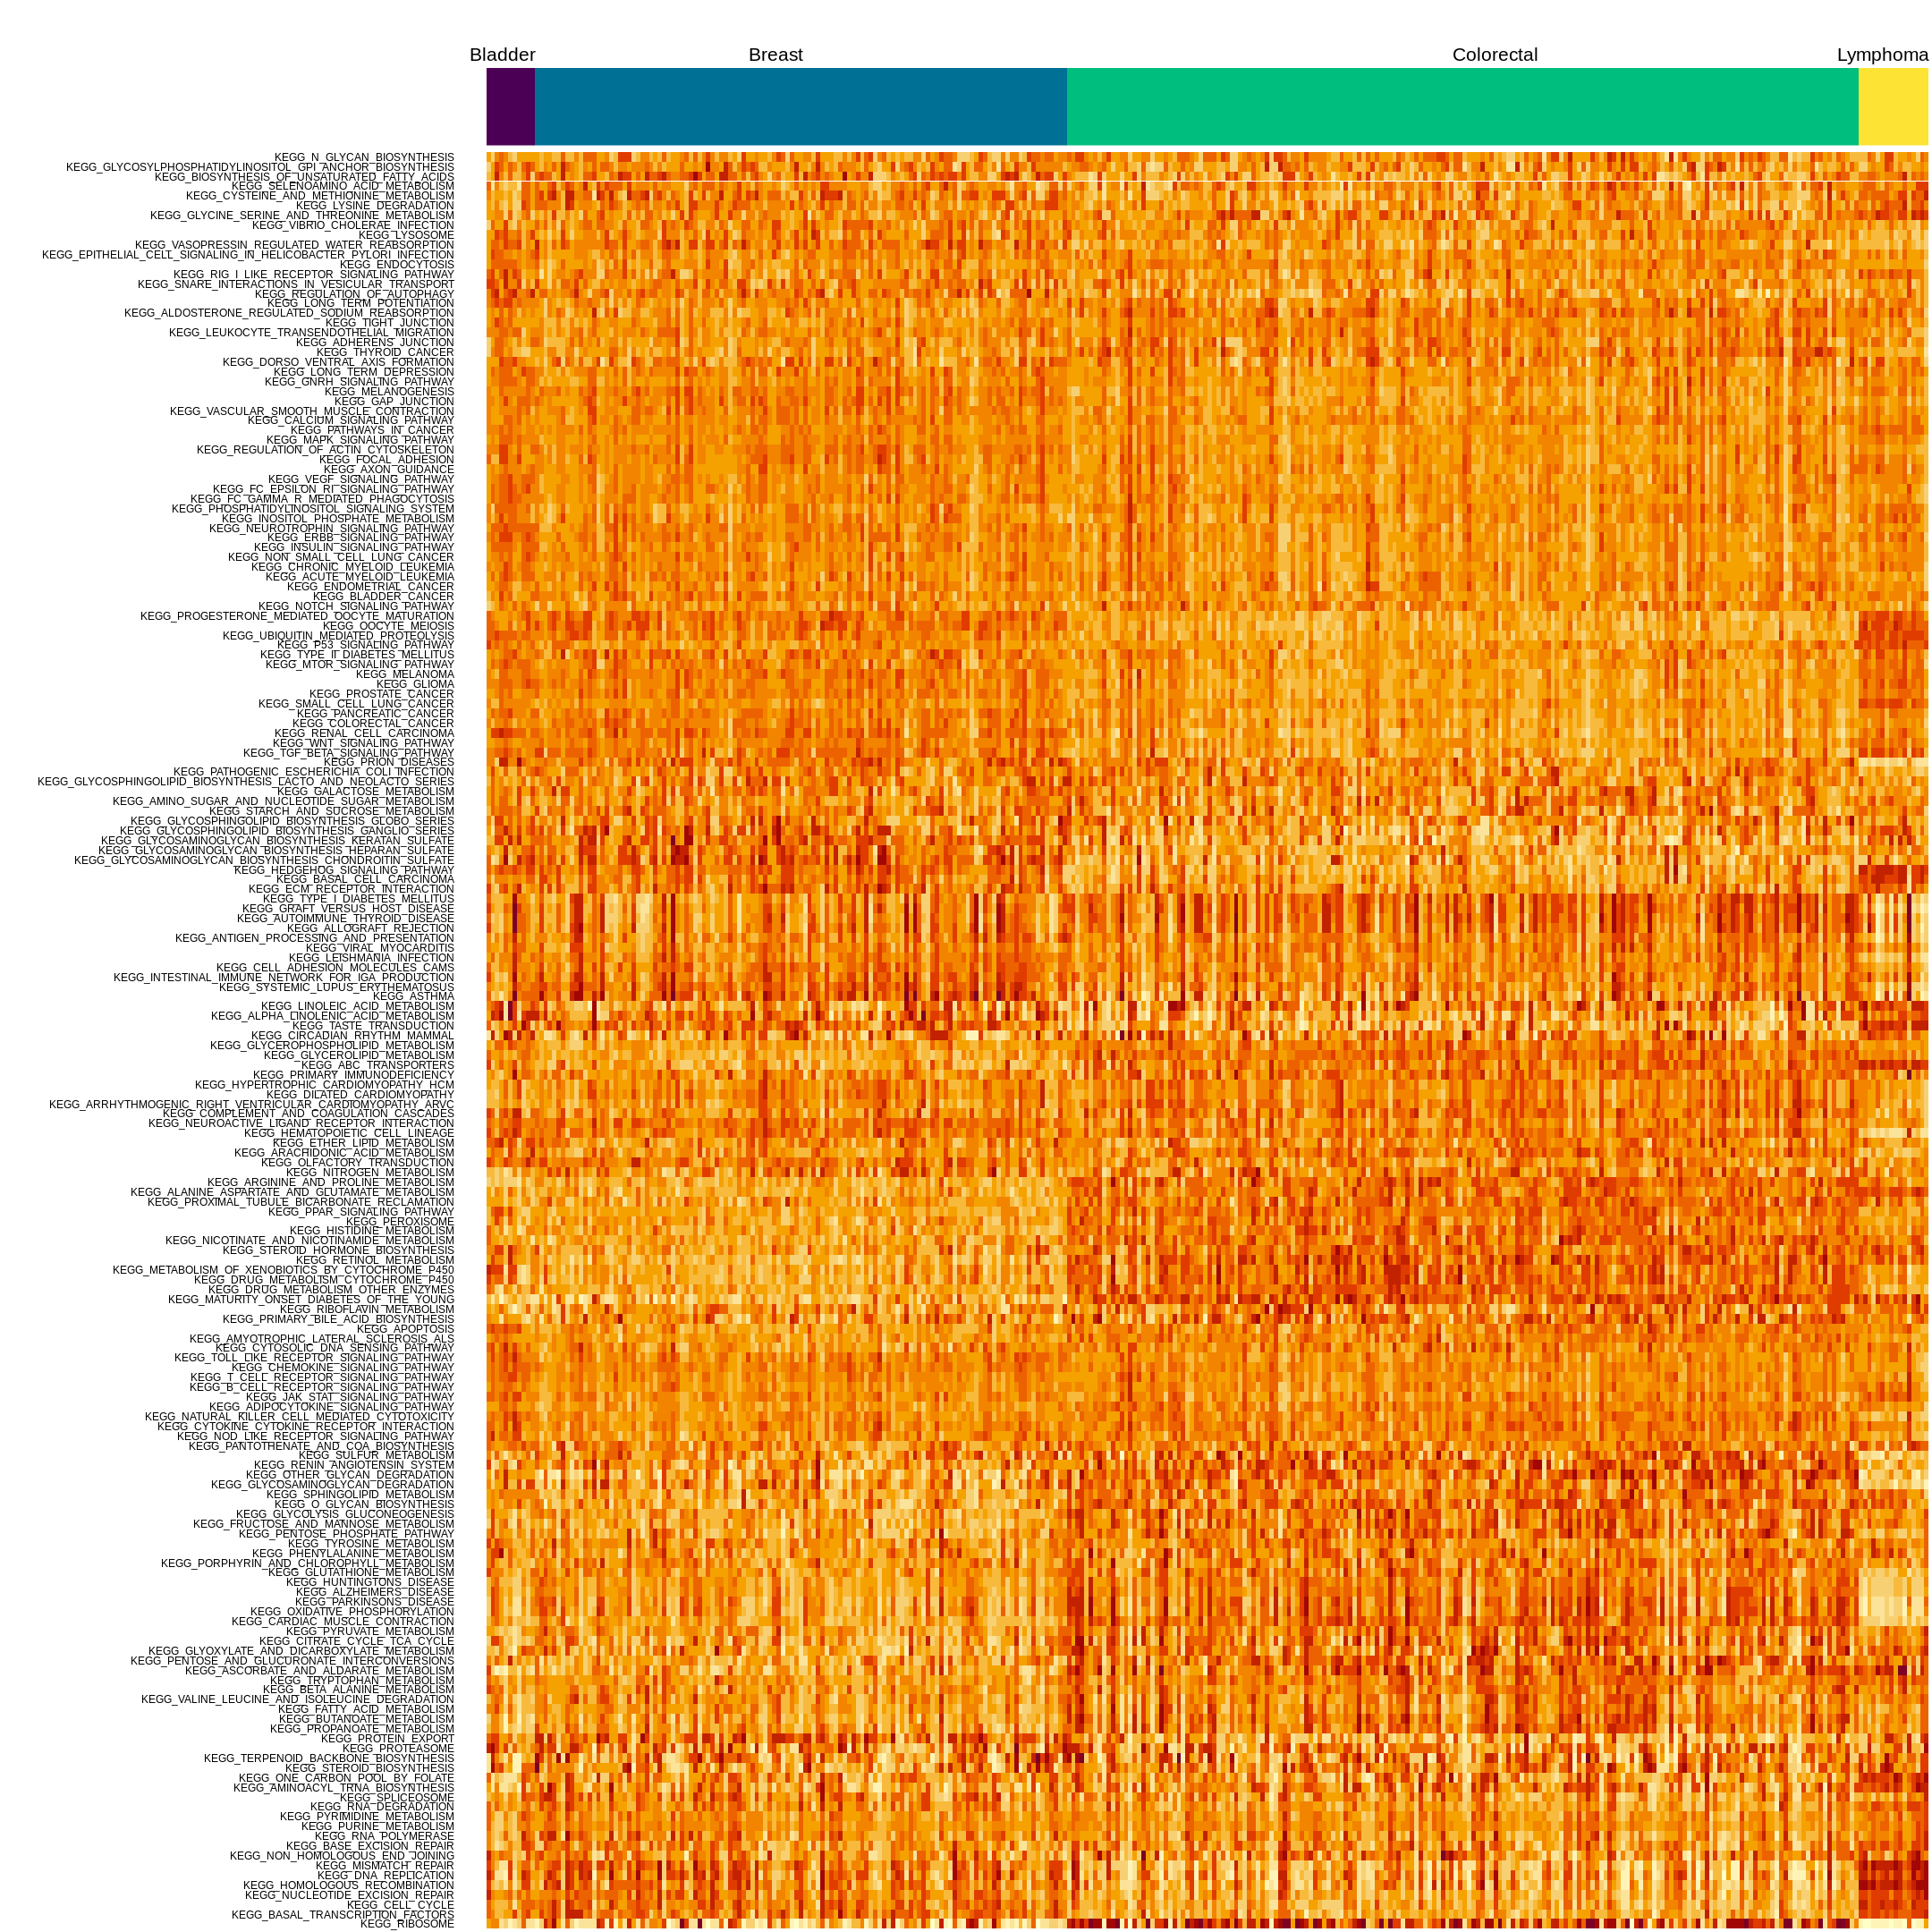

In [155]:
cancertype <- cancertype[order(cancertype[,'tumor_type']),]
cancertype <- cancertype[cancertype[,'model_name'] %in% colnames(pdx_gsva),]
cancertype[,'tumor_type'] <- as.factor(cancertype[,'tumor_type'])
# cluster gene sets
rw_d <- dist(pdx_gsva)
rw_cl <- hclust(rw_d)
pdx_gsva <- pdx_gsva[rw_cl$order, ] 
# Change plot size
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res=180)
layout(matrix(c(1,2)), heights=c(1,12))
par(mar=c(0,15,2,0)+0.1)
image(
    matrix(as.numeric(factor(cancertype[,'tumor_type']))), 
    axes=FALSE, 
    ann=FALSE, 
    main=NA, 
    col=hcl.colors(length(unique(cancertype$tumor_type)), "viridis")
)
#axis(side=3)
mtext(side=3, text=unique(cancertype[,'tumor_type']), at=c(0.01, 0.2, 0.7, 0.97), cex=0.7)
par(mar=c(0,15,0,0)+0.1)
image(t(pdx_gsva[,cancertype[,'model_name']]), axes=FALSE, ann=FALSE)
mtext(side=2, text=rownames(pdx_gsva), at=seq(0, 1, length.out=nrow(pdx_gsva)), line=1, las=2, cex=0.4)

## 6. Clustered Heatmap

In [132]:
# cluster samples
col_d <- dist(t(pdx_gsva))
col_cl <- hclust(col_d)
# re-order matrix for static printing
pdx_cl <- pdx_gsva[, col_cl$order] 
# re-order cancer types to match matrix
rownames(cancertype) <- cancertype[,'model_name']
cancertype <- cancertype[colnames(pdx_cl),]

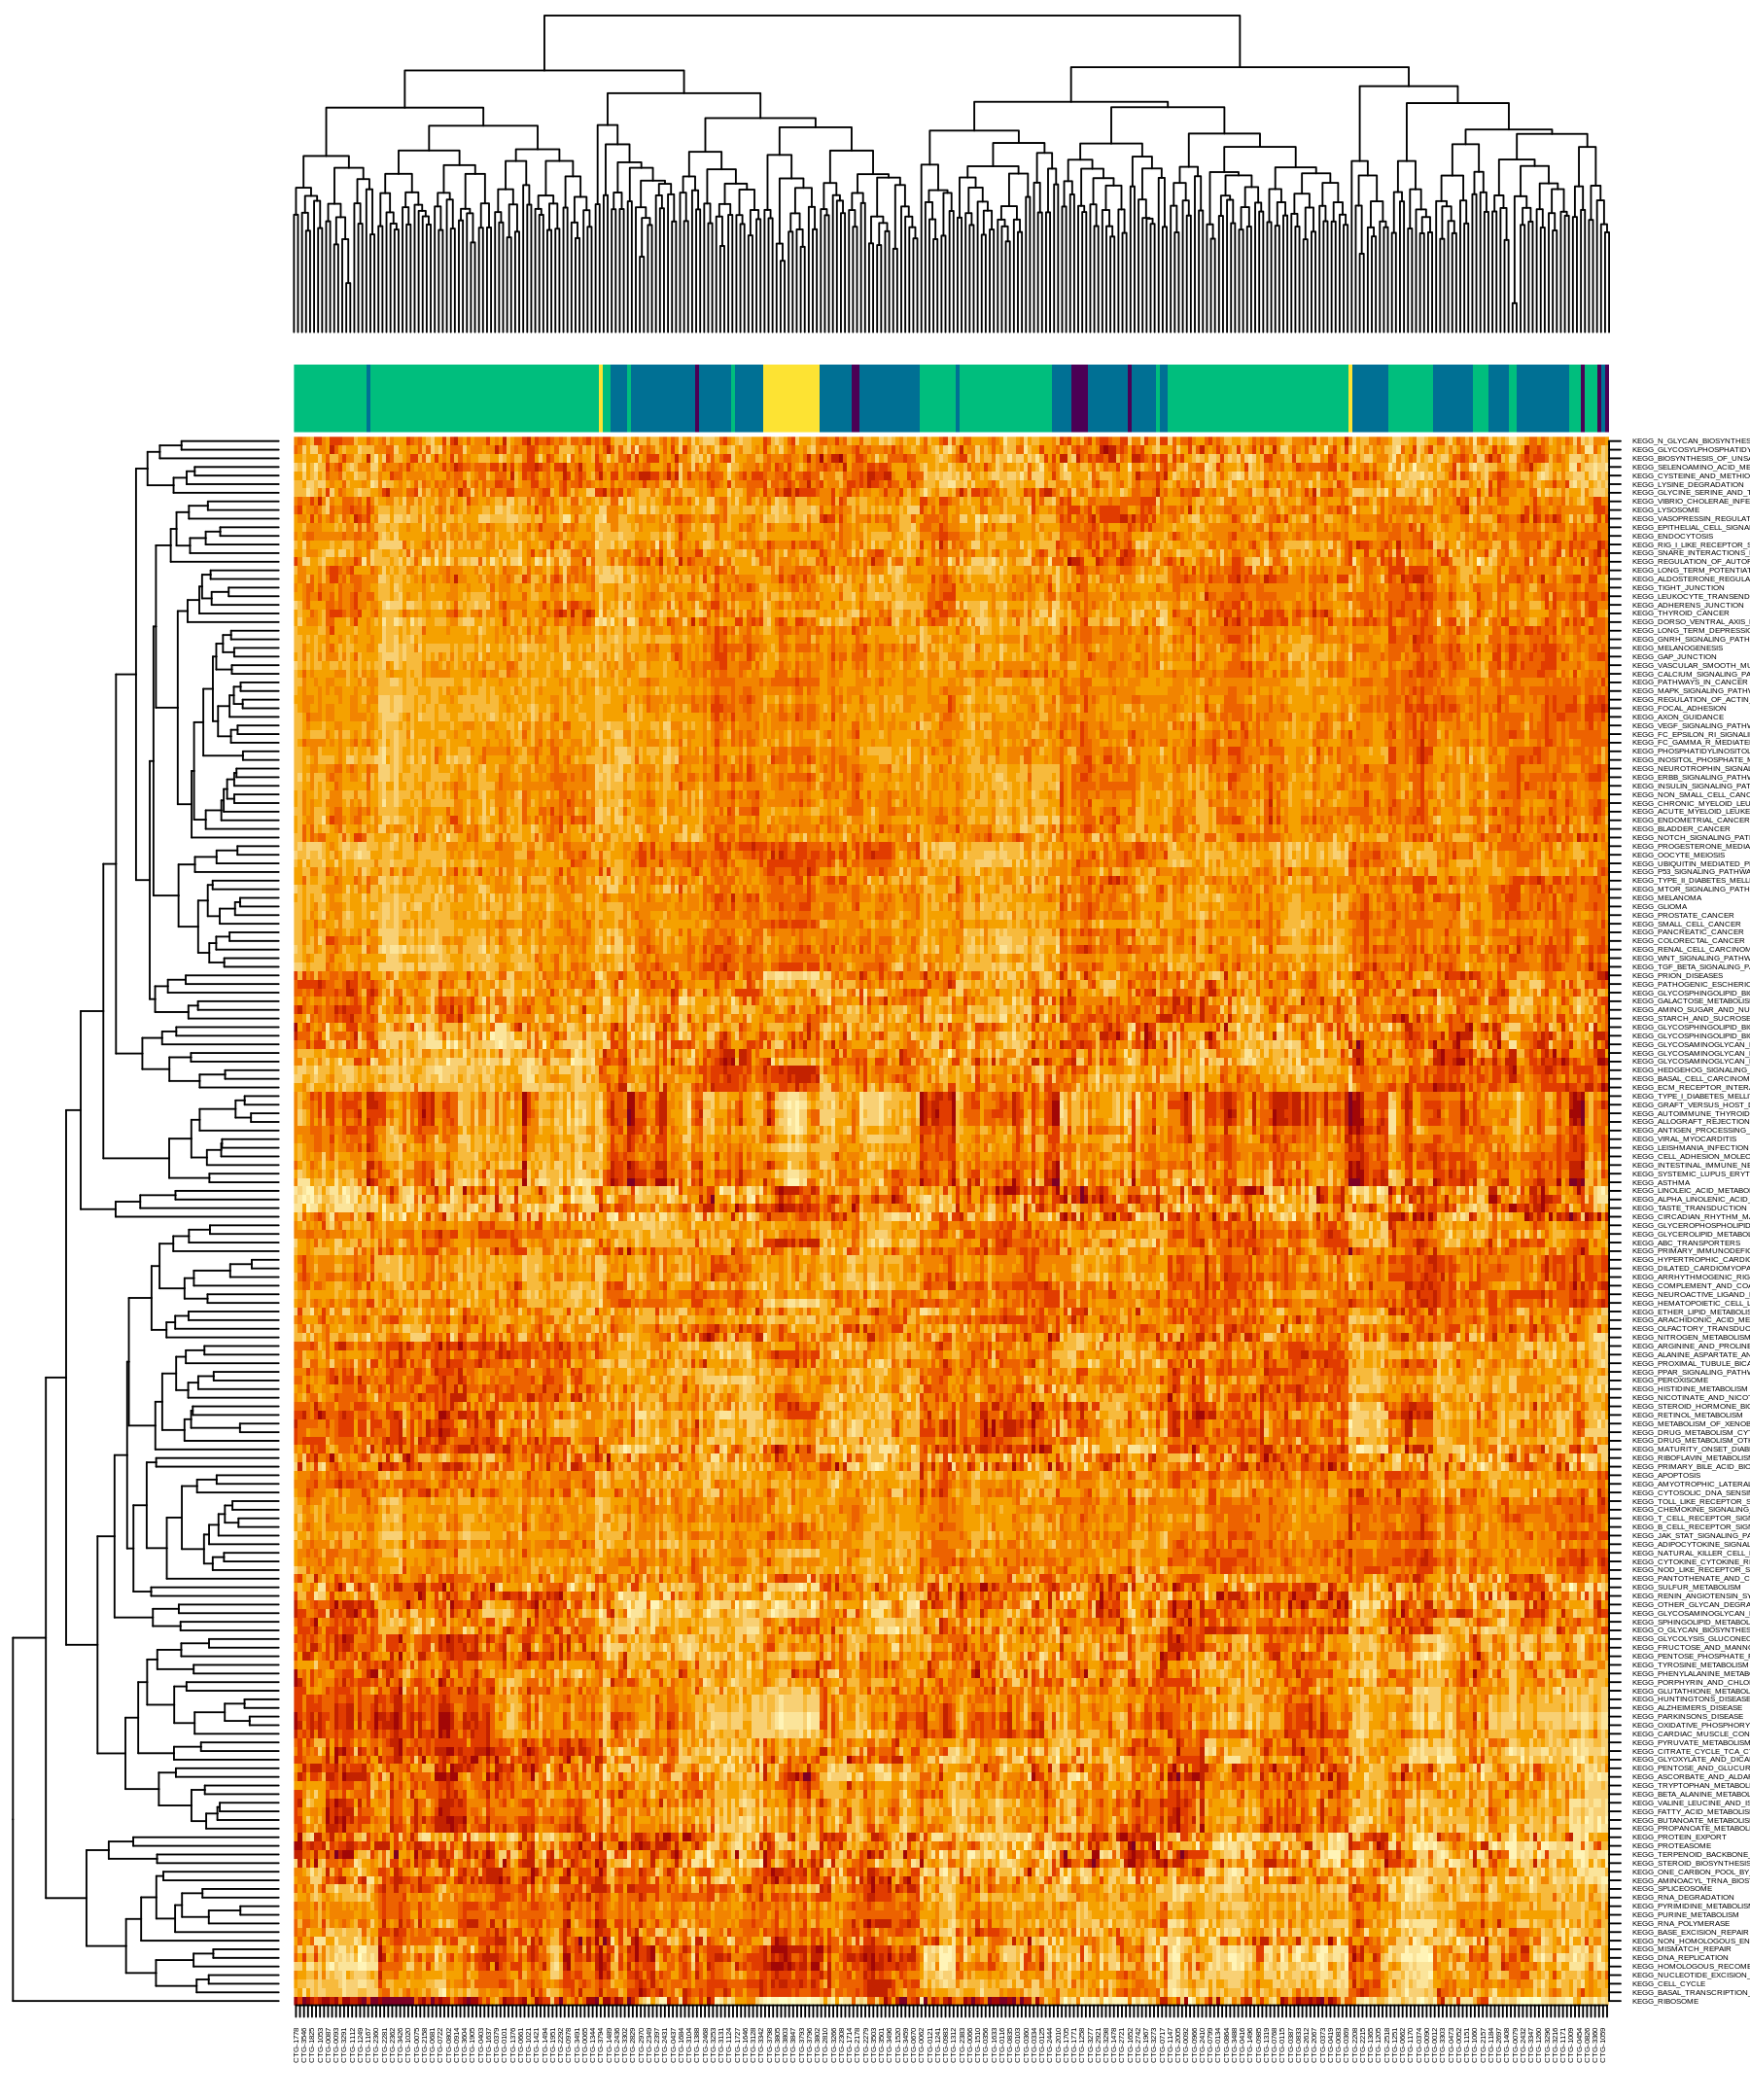

In [133]:
# Change plot size
options(repr.plot.width=10, repr.plot.height=12, repr.plot.res=180)
# layout our plot
graphics::layout(
    matrix(c(
        5,5,2,2,2,2,
        1,3,4,4,4,4,
        1,3,4,4,4,4,
        1,3,4,4,4,4,
        1,3,4,4,4,4,
        1,3,4,4,4,4
    ), ncol=6),
    heights=c(5,1,20)
)
# plot genes dengrogram
par(mar=c(0,0,0,6)+0.1)
plot(col_cl, labels = FALSE, hang = -0.1, axes = FALSE, ann = FALSE, xaxs="i")
# plot samples dendrogram
par(mar=c(4,0,0,0)+0.1)
plot(as.dendrogram(rw_cl), leaflab = 'none', axes = FALSE, ann = FALSE, horiz=TRUE, yaxs="i")
# plot cancer type
par(mar=c(0,0,0,6)+0.1)
image(
    matrix(as.numeric(cancertype[,'tumor_type'])), 
    axes=FALSE, 
    ann=FALSE, 
    main=NA, 
    col=hcl.colors(length(unique(cancertype$tumor_type)), "viridis")
)
# plot the heatmap
par(mar=c(4,0,0,6)+0.1)
image(x=0:ncol(pdx_cl), y=0:nrow(pdx_cl), z=t(pdx_cl), axes=FALSE, xlab=NA, ylab=NA)
axis(4, at=1:nrow(pdx_cl)-0.5, labels=gsub("_LUNG", "", rownames(pdx_cl)), las=2, cex.axis=0.4)
axis(1, at=1:ncol(pdx_cl)-0.5, labels=colnames(pdx_cl), las=3, cex.axis=0.4)

## 7. DGE of GSVA Between Colorectal and Breast Cancers

In [134]:
# Filter the models to our focal cancer types
dge_dat <- cancertype[cancertype[,'tumor_type'] %in% c("Breast", "Colorectal"),]
dge_dat[,'tumor_type'] <- droplevels(dge_dat[,'tumor_type'])
rownames(dge_dat) <- dge_dat[,'model_name']
# Filter the data to models that match our focal cancer types
dge_dat <- dge_dat[colnames(pdx_gsva), 'tumor_type', drop=FALSE]
dge_dat <- na.omit(dge_dat)
pdx_gsva <- pdx_gsva[,rownames(dge_dat)]
# Build the model that estimates t-statistics for each gene set
mod <- model.matrix(~0+tumor_type, dge_dat)
colnames(mod) <- gsub("tumor_type", "", colnames(mod))
fit <- limma::lmFit(pdx_gsva, mod)
fit <- limma::eBayes(fit)
res <- limma::decideTests(fit, p.value=0.01)
summary(res)

       Breast Colorectal
Down       49         57
NotSig     88         66
Up         45         59

In [135]:
tt <- limma::topTable(fit, coef=2, n=Inf)
DEpwys <- rownames(tt)[tt$adj.P.Val <= 0.01]

## 8. Volcano Plot

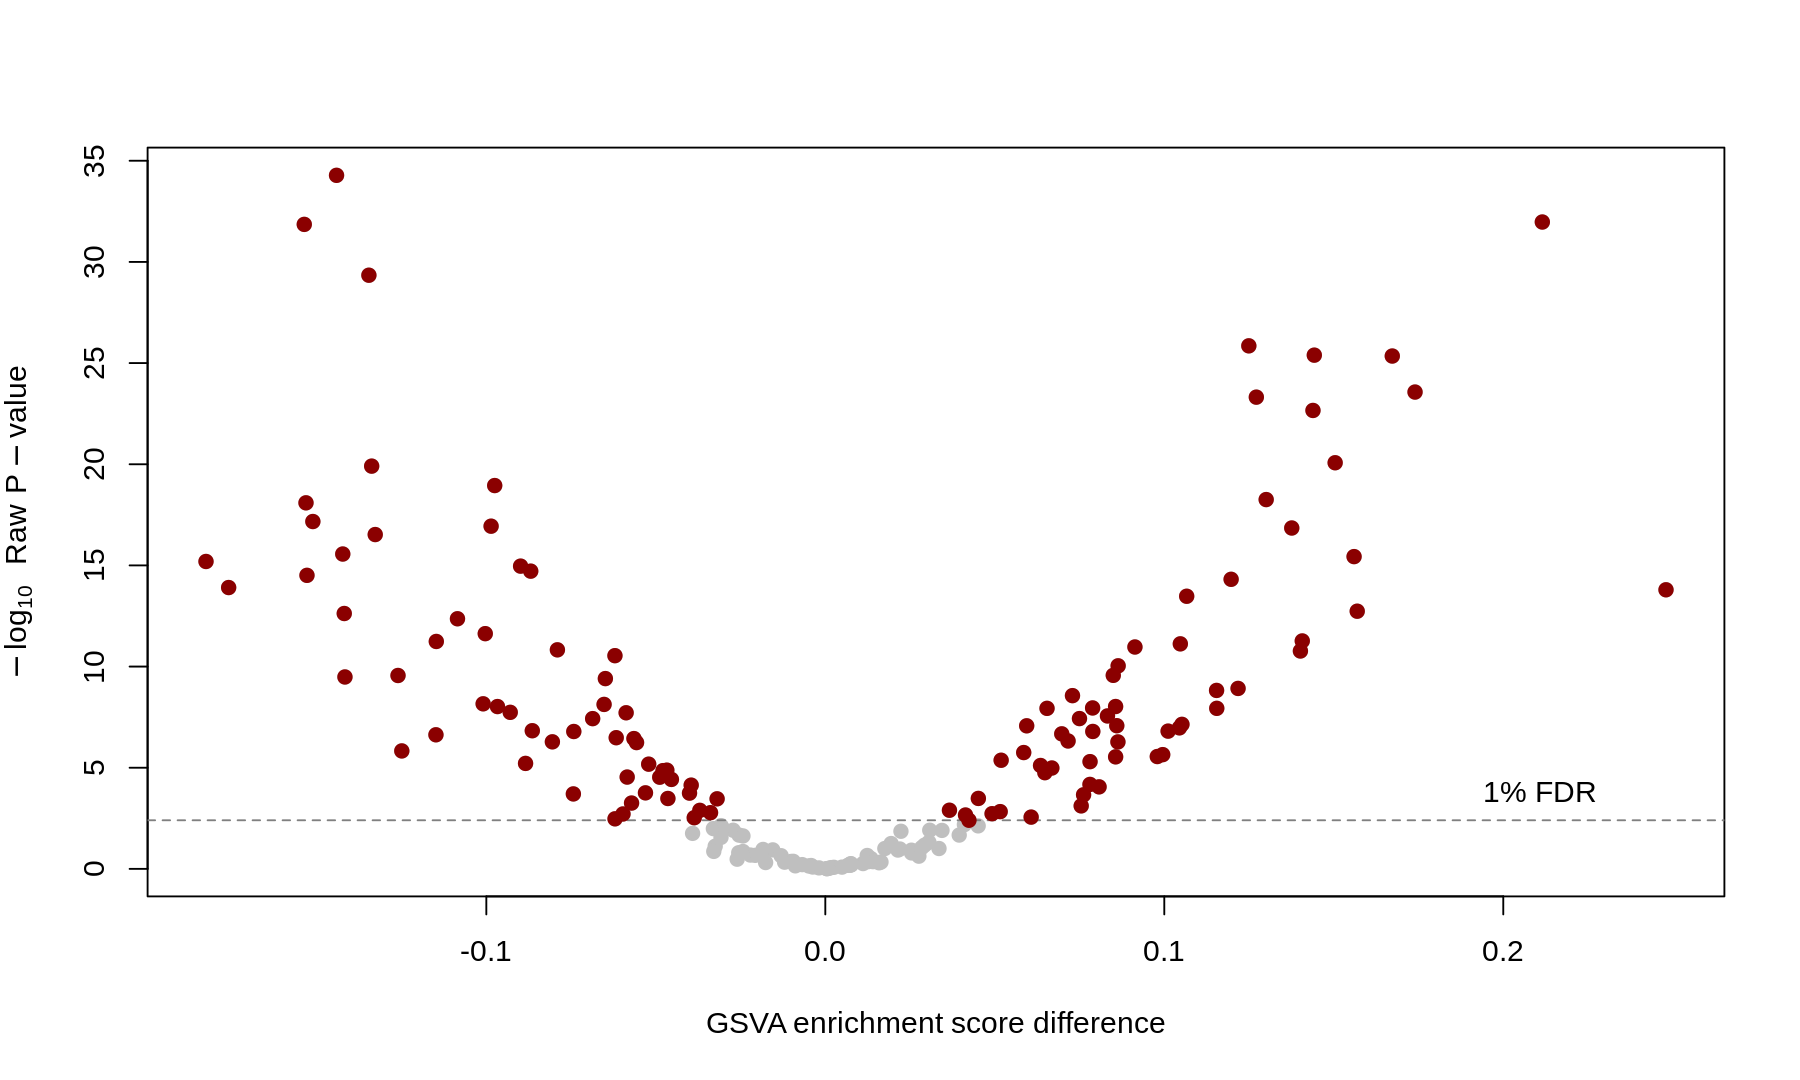

In [136]:
# Change plot size
options(repr.plot.width=10, repr.plot.height=6, repr.plot.res=180)
plot(
  tt$logFC, 
  -log10(tt$P.Value), 
  pch=19, 
  cex=1, 
  col=grey(0.75),
  main="", 
  xlab="GSVA enrichment score difference", 
  ylab=expression(-log[10]~~Raw~P-value)
)
abline(h=-log10(max(tt$P.Value[tt$adj.P.Val <= 0.01])), col=grey(0.5), lwd=1, lty=2)
points(
    tt$logFC[match(DEpwys, rownames(tt))],
    -log10(tt$P.Value[match(DEpwys, rownames(tt))]), 
    pch=19, 
    cex=1, 
    col="darkred"
)
text(
    max(tt$logFC)*0.85, 
    -log10(max(tt$P.Value[tt$adj.P.Val <= 0.01])), 
    "1% FDR", 
    pos=3
)

In [137]:
length(DEpwys)

[1] 116

There are 116 MSigDB KEGG differentially expressed pathways with FDR < 1%.  

In [138]:
tt

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS,-0.14418781,-0.06332998,-14.056794,5.251582e-35,9.557879e-33,68.80582
KEGG_MATURITY_ONSET_DIABETES_OF_THE_YOUNG,0.21151898,0.03871384,13.435911,1.066793e-32,8.470338e-31,63.55397
KEGG_OOCYTE_MEIOSIS,-0.15370805,-0.04438684,-13.404289,1.396210e-32,8.470338e-31,63.28802
KEGG_PROGESTERONE_MEDIATED_OOCYTE_MATURATION,-0.13464333,-0.03371092,-12.719522,4.545353e-30,2.068135e-28,57.57114
KEGG_PPAR_SIGNALING_PATHWAY,0.12493710,0.02753903,11.749073,1.405184e-26,5.114869e-25,49.63312
KEGG_DRUG_METABOLISM_OTHER_ENZYMES,0.14425441,0.03694838,11.618956,4.057906e-26,1.165645e-24,48.58597
KEGG_CARDIAC_MUSCLE_CONTRACTION,0.16725543,0.04976051,11.606698,4.483249e-26,1.165645e-24,48.48755
KEGG_RETINOL_METABOLISM,0.17397008,0.02594360,11.098035,2.705145e-24,6.154206e-23,44.44028
KEGG_GLYCEROLIPID_METABOLISM,0.12715212,0.01957458,11.025356,4.830238e-24,9.767814e-23,43.86814
